# Quora Question Pairs

_Can you identify question pairs that have the same intent?_



- [Kaggle competition link](https://www.kaggle.com/c/quora-question-pairs)
- [analytics vidya](https://www.analyticsvidhya.com/blog/2020/01/first-text-classification-in-pytorch/)

In [4]:
from sklearn import model_selection

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

DIR = '/kaggle/input'

In [7]:
!unzip /kaggle/input/quora-question-pairs/train.csv.zip

Archive:  /kaggle/input/quora-question-pairs/train.csv.zip
  inflating: train.csv               


In [8]:
!ls

__notebook_source__.ipynb  train.csv


# Create Fold for better validation set

In [9]:
df = pd.read_csv("train.csv")
df['kfold'] = -1

df = df.sample(frac=1.,random_state=2021).reset_index(drop=True)

kf = model_selection.StratifiedKFold(n_splits=5, shuffle=False)

for fold, (train_idx, val_idx) in enumerate(kf.split(X=df, y = df.is_duplicate.values)):
    print(len(train_idx), len(val_idx))
    df.loc[val_idx, 'kfold'] = fold

323432 80858
323432 80858
323432 80858
323432 80858
323432 80858


In [10]:
df.dropna(inplace=True)

In [11]:
df.question1.isna().sum(), df.question2.isna().sum(), df.question1.isnull().sum(), df.question2.isnull().sum()

(0, 0, 0, 0)

In [12]:
df.to_csv("train_folds.csv", index=False)

In [13]:
!ls

__notebook_source__.ipynb  train.csv  train_folds.csv


In [14]:
df_fold = pd.read_csv("train_folds.csv")

In [15]:
def sent_len(input_str: str):
    input_str = str(input_str)
    return len(input_str.strip().split(" "))

In [16]:
df_fold["question1_len"] = list(map(sent_len, df_fold.question1.values.tolist()))

In [17]:
df_fold["question2_len"] = list(map(sent_len, df_fold.question2.values.tolist()))

In [18]:
df_fold.head()

,id,qid1,qid2,question1,question2,is_duplicate,kfold,question1_len,question2_len
0,114488,186875,186876,"On Facebook messenger, what does a grey circle...",How do I remove the blue squiggle icon from th...,0,0,12,20
1,178457,274086,274087,Who decided that 36-24-36 is the perfect figur...,What is it like to be an Indian woman?,0,0,16,9
2,28495,52834,52835,Who are the A-List actors in Hollywood?,Who is the top actor right now in Hollywood?,0,0,7,9
3,293815,195024,183896,What are the main imports and exports of Venez...,What are the main imports and exports of Venez...,0,0,17,17
4,325846,452102,452103,What type of questions are in the airforce ada...,What is a question to test?,0,0,10,6


# Question length distribution

- Check sentence lengths before applying Sentence embedding of `512` dimension using **Universal Sentence Encoder**

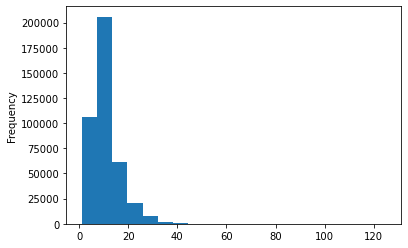

In [19]:
df_fold.question1_len.plot.hist(bins=20);

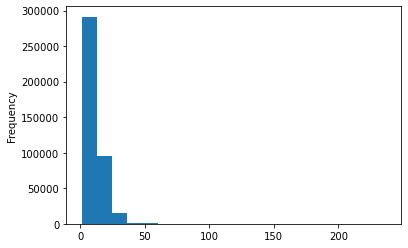

In [20]:
df_fold.question2_len.plot.hist(bins=20);

# Load Universal Sentence Encoder (USE)

In [21]:
import tensorflow_hub as hub

In [22]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [23]:
embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])



In [24]:
import torch

## Ensure reproducibility

In [25]:
#Reproducing same results
SEED = 2021

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True  

In [26]:
import torch.nn as nn

In [27]:
BATCH_SIZE = 256

# Design Train Dataloader

In [28]:
from torch.utils.data import DataLoader, Dataset

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [30]:
class QuoraTrainData(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        q1 = self.df.iloc[idx].question1
        q2 = self.df.iloc[idx].question2
        label = self.df.iloc[idx].is_duplicate
        
        return {"q1": q1, "q2": q2, "label": label}

In [31]:

FOLD_MAPPPING = {
    0: [1, 2, 3, 4],
    1: [0, 2, 3, 4],
    2: [0, 1, 3, 4],
    3: [0, 1, 2, 4],
    4: [0, 1, 2, 3]
}

In [32]:
FOLD = 0

In [33]:
train_df = df_fold[df_fold.kfold.isin(FOLD_MAPPPING.get(FOLD))].reset_index(drop=True)
valid_df = df_fold[df_fold.kfold==FOLD].reset_index(drop=True)

In [34]:
train_df.shape, valid_df.shape

((323430, 9), (80857, 9))

In [35]:
valid_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,kfold,question1_len,question2_len
0,114488,186875,186876,"On Facebook messenger, what does a grey circle...",How do I remove the blue squiggle icon from th...,0,0,12,20
1,178457,274086,274087,Who decided that 36-24-36 is the perfect figur...,What is it like to be an Indian woman?,0,0,16,9
2,28495,52834,52835,Who are the A-List actors in Hollywood?,Who is the top actor right now in Hollywood?,0,0,7,9
3,293815,195024,183896,What are the main imports and exports of Venez...,What are the main imports and exports of Venez...,0,0,17,17
4,325846,452102,452103,What type of questions are in the airforce ada...,What is a question to test?,0,0,10,6


In [36]:
train_dataset = QuoraTrainData(train_df)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [37]:
valid_dataset = QuoraTrainData(valid_df)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Check train dataset

In [38]:
# 5th example
train_dataset.__getitem__(5)

{'q1': 'What is the most common business of millionaires?',
 'q2': 'What are the most common routes that create young millionaires?',
 'label': 1}

In [39]:
valid_dataset.__getitem__(5)

{'q1': 'Where can I get very competitive assistance in Eastern Suburbs for commercial water heater installation & service?',
 'q2': 'Where can I get very affordable services for water heater installation in Eastern Suburbs?',
 'label': 0}

## Check train dataloader

In [40]:
train_iter = iter(train_loader)
res = train_iter.next()

In [41]:
res

{'q1': ['Would it have decreased the rate of rapes in India, if prostitution were made legal?',
  'What are the differences between a love marriage and an arranged marriage?',
  "Why isn't Quora listed in Klout?",
  'I want to become a Machine learning engineer. Should I take a machine learning master degree or instead a Udacity nanodegree?',
  'How good is the book "Probability and Statistical Inference" by Nitis Mukhopadhyay?',
  'Can somebody help me to solve this problems?',
  'How important is sex in a successful relationship?',
  'What online payment methods are most popular in Yemen?',
  'Which books/novels should I gift to my wife / girlfriend / fiance? (Why?) Which one should be the first ?',
  'Is it possible to get pregnant before period or after period ends?',
  'What is the best command line tools to test restful API (node)?',
  'How do I overcome my inferiority complex ?',
  'How do I get a job in IT sector without shifts?',
  'How much do partners make at top law firms?'

# Design Model

## Architecture

- [Idea from Abhishek Thakur](https://www.linkedin.com/pulse/duplicate-quora-question-abhishek-thakur/)

<center>
    <img src='../images/NN_Architecture.jpg' width='400'>
    
</center>

## Multilayer Perceptron (Linear model)

In [42]:
class IsDuplicate(nn.Module):
    def __init__(self, output_dim: int, emb_dim: int, hid_dim=512):
        """Simple MultiLayerPerceptron
            Linear model
        """
        super().__init__()
        #dense layer
        self.fc1 = nn.Linear(emb_dim * 2, hid_dim)
        
        self.fc2 = nn.Linear(hid_dim, output_dim)
        
        #activation function
        self.act = nn.Sigmoid()
        
    def forward(self, text1:[str], text2:[str]):
        """
        text1: list of strings from question1, len: batch_size
        text2: list of strings from question2, len: batch_size
        """
        
        emb1 = embed(text1)
        e1 = torch.from_numpy(emb1.numpy()).to(device)
        # e1.size()
        
        emb2 = embed(text2)
        e2 = torch.from_numpy(emb2.numpy()).to(device)
        # e2.size()
        
        hidden = torch.cat((e1, e2), dim = 1)
        
        #hidden = [batch size, hid dim * num directions]
        dense_outputs1=self.fc1(hidden)
        dense_outputs2=self.fc2(dense_outputs1)

        #Final activation function
        outputs=self.act(dense_outputs2)
        
        return outputs

## Non-linear deeper model

In [43]:
class IsDuplicateAdv(nn.Module):
    def __init__(self, output_dim: int, emb_dim: int, hid_dim=512):
        """Non Linear model
        """
        super().__init__()
        #dense layer
        
        self.batchnorm1 = nn.BatchNorm1d(emb_dim * 2)
        self.dropout = nn.Dropout(p=0.2)
        self.nonlinear = nn.PReLU()
        
        self.fc1 = nn.Linear(emb_dim * 2, hid_dim)
        self.batchnorm2 = nn.BatchNorm1d(hid_dim)
        self.fc2 = nn.Linear(hid_dim, output_dim)
        
        #activation function
        self.act = nn.Sigmoid()
        
    def forward(self, text1:[str], text2:[str]):
        """
        text1: list of strings from question1, len: batch_size
        text2: list of strings from question2, len: batch_size
        """
        
        emb1 = embed(text1)
        e1 = torch.from_numpy(emb1.numpy()).to(device)
        
        emb2 = embed(text2)
        e2 = torch.from_numpy(emb2.numpy()).to(device)
        
        # merged
        x = torch.cat((e1, e2), dim = 1)
        x = self.batchnorm1(x)
        
        
        x=self.fc1(x)
        x = self.nonlinear(x)
        x = self.dropout(x)
        x = self.batchnorm2(x)
        
        x=self.fc2(x)

        #Final activation function
        outputs=self.act(x)
        
        return outputs

## Test model

In [44]:
model = IsDuplicateAdv(output_dim=2, emb_dim=512).to(device)

prob = model(text1= res['q1'], text2 = res['q2'])

In [45]:
prob

tensor([[0.4180, 0.4529],
        [0.6072, 0.3970],
        [0.4349, 0.3845],
        [0.5906, 0.2811],
        [0.5912, 0.5896],
        [0.6489, 0.3896],
        [0.6072, 0.6204],
        [0.6927, 0.5849],
        [0.6786, 0.3380],
        [0.4490, 0.5158],
        [0.5081, 0.5857],
        [0.5790, 0.3876],
        [0.6260, 0.3591],
        [0.6701, 0.5734],
        [0.3186, 0.4479],
        [0.5146, 0.2941],
        [0.3445, 0.4910],
        [0.6449, 0.4397],
        [0.3178, 0.8497],
        [0.6909, 0.4778],
        [0.3922, 0.3653],
        [0.7983, 0.5951],
        [0.6286, 0.5278],
        [0.3575, 0.4270],
        [0.4866, 0.5178],
        [0.6305, 0.5303],
        [0.6855, 0.6353],
        [0.1862, 0.5921],
        [0.6901, 0.4636],
        [0.6041, 0.2694],
        [0.2500, 0.5107],
        [0.2580, 0.5159],
        [0.5116, 0.3391],
        [0.7193, 0.3234],
        [0.5393, 0.5261],
        [0.4500, 0.6376],
        [0.5675, 0.5866],
        [0.5385, 0.5409],
        [0.5

In [46]:
#torch.argmax(prob, dim=1)

In [47]:
#prob[:,1], prob[:,0]

In [48]:
print(model)

IsDuplicateAdv(
  (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (nonlinear): PReLU(num_parameters=1)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (batchnorm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (act): Sigmoid()
)


In [49]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| batchnorm1.weight |    1024    |
|  batchnorm1.bias  |    1024    |
|  nonlinear.weight |     1      |
|     fc1.weight    |   524288   |
|      fc1.bias     |    512     |
| batchnorm2.weight |    512     |
|  batchnorm2.bias  |    512     |
|     fc2.weight    |    1024    |
|      fc2.bias     |     2      |
+-------------------+------------+
Total Trainable Params: 528899


528899

# Set Optimizer and Loss

In [50]:
import torch.optim as optim

#define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

In [51]:
#??optim.Adam

## `BCEWithLogitLoss()` more stable than `Sigmoid()` + `BCELoss()`. Why?

> `Sigmoid()` + `BCELoss()` = `BCEWithLogitLoss()`



- [Ans](https://discuss.pytorch.org/t/bce-loss-vs-cross-entropy/97437/2)



In [52]:
#define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.argmax(preds, dim=1)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
#push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

## Train

In [56]:
def train(model, train_data_loader, optimizer, criterion):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  
    
    n_batch = len(train_data_loader)
    for i, batch in enumerate(train_data_loader):
        
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words
        q1, q2, label = batch['q1'], batch['q2'], batch['label'] 
        
        label = label.to(device)
        #convert to 1D tensor
        predictions = model(q1, q2)
        
        #print(predictions.dtype)
        #print(label.float().dtype)
        #compute the loss
        loss = criterion(predictions[:,1], label.float())        
        
        #compute the binary accuracy
        acc = binary_accuracy(predictions, label.float())   
        
        #backpropage the loss and compute the gradients
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        batch_loss = loss.item()
        batch_acc = acc.item() 
        epoch_loss += batch_loss  
        epoch_acc +=  batch_acc  
        if i % 100 == 0:
            print(f"\t\t\t > trn batch_no: {i}/{n_batch}, batch_loss: {np.round(batch_loss/BATCH_SIZE, 4)}, batch_acc: {np.round(batch_acc/BATCH_SIZE, 4)}")
        
    return epoch_loss / len(train_data_loader), epoch_acc / len(train_data_loader)

## Evaluate

In [57]:
def evaluate(model, valid_data_loader, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    n_batch = len(valid_data_loader)
    with torch.no_grad():
    
        for i, batch in enumerate(valid_data_loader):
        
            #retrieve question pair and labels
            q1, q2, label = batch['q1'], batch['q2'], batch['label']
            label = label.to(device)
            #convert to 1d tensor
            predictions = model(q1, q2)
            
            #compute loss and accuracy
            
            loss = criterion(predictions[:,1], label.float())
            acc = binary_accuracy(predictions, label.float())
            
            #loss and accuracy
            batch_loss = loss.item()
            batch_acc = acc.item() 
            epoch_loss += batch_loss  
            epoch_acc +=  batch_acc 
            if i % 50 == 0:
                print(f"\t\t\t > val batch_no: {i}/{n_batch}, batch_loss: {np.round(batch_loss/BATCH_SIZE,4)}, batch_acc: {np.round(batch_acc/BATCH_SIZE, 4)}")
            
        
    return epoch_loss / len(valid_data_loader), epoch_acc / len(valid_data_loader)


## Train Loop

In [58]:
N_EPOCHS = 5
best_valid_loss = float('inf')

history = {
    "train_loss": [],
    "train_acc": [],
    "valid_loss": [],
    "valid_acc": []
}

for epoch in range(N_EPOCHS):
     
    #train the model
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    
    #evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion)
    
    train_loss = np.round(train_loss,4)
    train_acc = np.round(train_acc, 4)
    valid_loss = np.round(valid_loss, 4)
    valid_acc = np.round(valid_acc, 4)
    
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["valid_loss"].append(valid_loss)
    history["valid_acc"].append(valid_acc)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'Epoch: {epoch+1}/{N_EPOCHS} \tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

			 > trn batch_no: 0/1264, batch_loss: 0.0029, batch_acc: 0.002
			 > trn batch_no: 100/1264, batch_loss: 0.0023, batch_acc: 0.0025
			 > trn batch_no: 200/1264, batch_loss: 0.0022, batch_acc: 0.0026
			 > trn batch_no: 300/1264, batch_loss: 0.0024, batch_acc: 0.0025
			 > trn batch_no: 400/1264, batch_loss: 0.0021, batch_acc: 0.0027
			 > trn batch_no: 500/1264, batch_loss: 0.0018, batch_acc: 0.0029
			 > trn batch_no: 600/1264, batch_loss: 0.002, batch_acc: 0.0029
			 > trn batch_no: 700/1264, batch_loss: 0.002, batch_acc: 0.0028
			 > trn batch_no: 800/1264, batch_loss: 0.002, batch_acc: 0.0027
			 > trn batch_no: 900/1264, batch_loss: 0.0018, batch_acc: 0.003
			 > trn batch_no: 1000/1264, batch_loss: 0.0017, batch_acc: 0.003
			 > trn batch_no: 1100/1264, batch_loss: 0.002, batch_acc: 0.0028
			 > trn batch_no: 1200/1264, batch_loss: 0.0017, batch_acc: 0.0031
			 > val batch_no: 0/316, batch_loss: 0.0017, batch_acc: 0.0032
			 > val batch_no: 50/316, batch_loss: 0.0017, batch_acc

In [59]:
history

{'train_loss': [0.5086, 0.3958, 0.3489, 0.3197, 0.2984],
 'train_acc': [0.7259, 0.7995, 0.8284, 0.8458, 0.8588],
 'valid_loss': [0.4272, 0.3713, 0.35, 0.3429, 0.338],
 'valid_acc': [0.7827, 0.8178, 0.8301, 0.8371, 0.84]}

# Performance

In [60]:
%matplotlib inline
from matplotlib import pyplot as plt

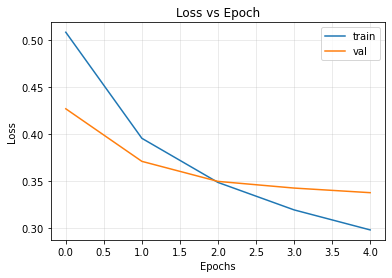

In [61]:
plt.plot(history["train_loss"], label="train")
plt.plot(history["valid_loss"], label="val")
plt.title("Loss vs Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

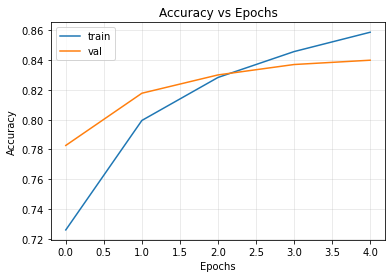

In [62]:
plt.plot(history["train_acc"], label="train")
plt.plot(history["valid_acc"], label="val")
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Inference

- TODO